# Taller 2: Modelos de aprendizaje supervisado aplicado a la detección de diabetes

## Introducción al trabajo

Agregar descripción

## Objetivos del trabajo

- Aquí va
- Un listado
- De objetivos

## 0. Pits

In [66]:
# origen del visitante
entorno_trabajo = 'local'

# básicos de cocina
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# alistamiento de datos
from sklearn.model_selection import train_test_split
# modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# evaluación
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
# optimizacion
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# popurri
from sklearn.tree import export_graphviz
from IPython.display import Image
from io import StringIO
import pydotplus
from sklearn import tree
#
#--------------------------------------------------------
# existe un error en la convergencia de datos para el modelo de reg log
# es un dataset sintetico, por ende, error esperado
# desactivaremos este tipo de errores
import warnings
from sklearn.exceptions import ConvergenceWarning
#--------------------------------------------------------
# instalación de librerías faltantes
try:
    from six import StringIO
    import pydotplus
except:
    %pip install graphviz pydotplus
    %pip install six
    %pip install pydotplus
    from six import StringIO
    import pydotplus

In [2]:
# Prelomonar a la carga
def invocar_dataset(ds_path, entorno = entorno_trabajo):
    """Carga dataset a partir del entorno de trabajo.

    Args:
        ds_path (str): Ubicacion válida del archivo, URL o ubicación local.
        entorno (str, optional): Entorno de trabajo: local o colab. Defaults to entorno_trabajo.

    Returns:
        dataframe: Si la carga es correcta, devolverá el objeto de pandas dataframe.
    """
    # Swith
    if entorno == "colab":
        try:
            # Using google colab
            from google.colab import drive
            drive.mount('/content/drive')
            return pd.read_csv(ds_path)
        except:
        # if not...
            return pd.read_csv(ds_path)
    elif entorno == "local":
        return pd.read_csv(ds_path)
    else:
        print("No hay suficientes combinaciones")

## 1. Carga y validación del dataset

Carga de un dataset. Se utiliza un bloque try-except para combinar uso de Google Drive/Conexión local.

In [6]:
pt_drive = "drive/MyDrive/data/diabetes.csv" # no tan util para ejecuciones compartidas
try:
    pt_local = "../datasets/diabetes.csv"
    df = invocar_dataset(pt_local)
except:
    pt_git = (
    "https://raw.githubusercontent.com/ljpiere/class_notes/"
    "main/datasets/diabetes.csv"
    )
    df = invocar_dataset(pt_git)

Verificamos carga del dataset correcta.

In [7]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## 2. Exploración del dataframe

### 2.1 Renombre de columnas

Algunas columnas tienen unos nombres algo extensos. Se renombra para más facilidad.

In [8]:
df.columns = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']

Validamos cambio.

In [9]:
df.head()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### 2.2 Verificación de valores nulos

Un loop nos ayudará a validar de primera mano la cantidad de vacíos en cada columna.

In [10]:
for i in df.columns:
  print("Column: ", i, "Null values: ", df[i].isnull().sum())

Column:  pregnant Null values:  0
Column:  glucose Null values:  0
Column:  bp Null values:  0
Column:  skin Null values:  0
Column:  insulin Null values:  0
Column:  bmi Null values:  0
Column:  pedigree Null values:  0
Column:  age Null values:  0
Column:  label Null values:  0


### 2.3 Verificando balanceo de clases

La variable a predecir es la columna `label`. Esta indica `0` si el paciente no fue diagnosticado con diabetes y `1` si el paciente fue diagnosticado con diabetes. 

<Axes: title={'center': 'Conteo de clases'}, xlabel='label'>

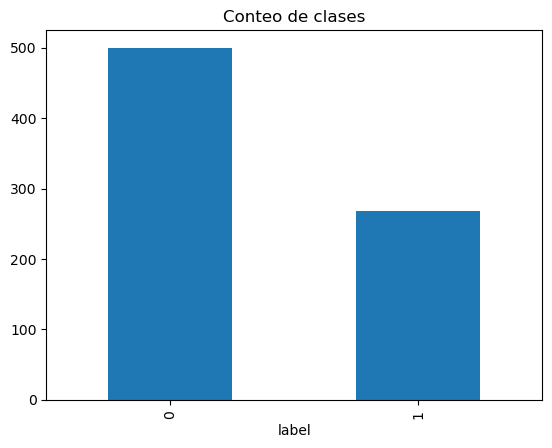

In [11]:
df.groupby('label')['label'].count().plot(kind='bar', title='Conteo de clases')

Las clases están desbalanceadas, esto es, tenemos más datos de la etiqueta `1` que de la etiqueta `0`. Esto significará un problema más adelante. 

### 2.4 Correlación de features

<Axes: >

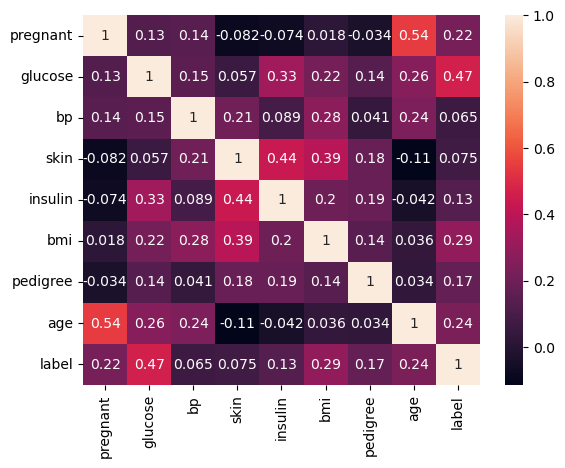

In [12]:
sns.heatmap(df.corr(), annot=True)

Tenemos algunos puntos a resaltar de este análisis de correlación:
- La edad, la glucosa y el bmi dan algunos indicios en la predicción.
- No observamos correlaciones fuertes, tanto positivas como negativas.
- Posiblemente nuestro modelo tome como "importantes" algunas features. Creemos que no serán todas importantes.

## 3. Selección de features

Vamos a trabajar con solo un grupo de features para este ejercicio. Definiremos el conjunto X con las features utilizadas para predecir y el conjunto y solo con la etiqueta de diagnóstico.

In [13]:
feature_cols = ['pregnant', 'insulin', 'bmi', 'age','glucose','bp','pedigree']
X = df[feature_cols]
y = df.label

## 4. Split de datos

Debemos delimitar los datos para entrenar y probar nuestro modelo.

- Se deine un tamaño de conjunto de testeo `test` tomando el 25 % de los datos del conjunto global para `X` y `y`.
- Creamos los conjuntos `train` y `test` a partir de ese porcentaje de división.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=16)

Fijamos el parámetro `random_state` como 16.

## 5. Busqueda del "mejor" modelo de Machine learning

### Metodología propuesta

Se definirán distintos modelos. Buscamos un paso a paso "general" para cada modelo distinto. Para evitar caer en reprocesos, se propone la siguiente metodología:

_Para cada modelo:_
- **Punto de salida:** Un modelo benchmark básico sin optimizar que marcará el escenario básico a superar.
- **Apuntar bien:** Buscaremos evaluar el accuaracy de nuestros modelos.
- **Barajar:** Cada modelo se evaluará usando una busqueda por cuadrilla, donde se evaluarán distintas combinaciones de hiperparámetros. Incluiremos el `random_state`. _**Apunte:**_ Se manajerán listas de valores similares para hiperparámetros que los modelos compartan entre si.
- **EL mejor de los mejores:** El modelo seleccionado deberá superar el modelo de benchmark.
- **Aleatoriedad:** Buscaremos mantener semillas iguales o bien, generar diferentes modelos para diferentes semillas.

### Recetario

Definiremos algunas funciones que nos permitirán hacer evaluaciones rápidas a partir de la reutilización de código.

In [18]:
def puesta_punto_modelo(model, X_train, X_test, y_train, y_test):
    """Entrenamiento, prediccion y evaluación del accuaracy para un
    modelo de clasificación.

    Args:
        model (sklearn): Modelo a entrenar, predecir y evaluar.
        X_train (list): Conjunto de features de entrenamiento.
        x_test (list): Conjunto de features de testeo.
        y_train (list): Conjunto de labels de entrenamiento.
        y_test (list): Conjunto de labels de testeo

    Returns:
        list: Predicciones, matriz de confuncion y accuaracy.
    """
    model_f = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    acc = metrics.accuracy_score(y_test, y_pred)
    
    return model_f, y_pred, cnf_matrix, acc

### 5.1 Regresión logística

#### Benchmark

Generemos un modelo básico.

In [22]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    logreg_bch = LogisticRegression(random_state=16)
    logreg_bch, y_pred_logreg_bch, cnf_matrix_logreg_bch, acc_logreg_bch = puesta_punto_modelo(logreg_bch, X_train, X_test, y_train, y_test)

In [ ]:
# calculo de su exactitud
acc_logreg_bch

0.8177083333333334

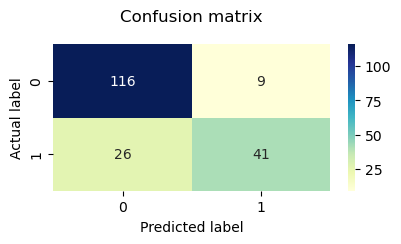

In [ ]:
class_names=[0,1] # name  of classes
tick_marks = np.arange(len(class_names))
# create heatmap
plt.figure(figsize=(4,2))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix_logreg_bch), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

Nada mal para un primer modelo.

In [51]:
target_names = ['without diabetes', 'with diabetes']
print(classification_report(y_test, y_pred_logreg_bch, target_names=target_names))

                  precision    recall  f1-score   support

without diabetes       0.82      0.93      0.87       125
   with diabetes       0.82      0.61      0.70        67

        accuracy                           0.82       192
       macro avg       0.82      0.77      0.78       192
    weighted avg       0.82      0.82      0.81       192



Recall cae frente a los pacientes con diabetes.

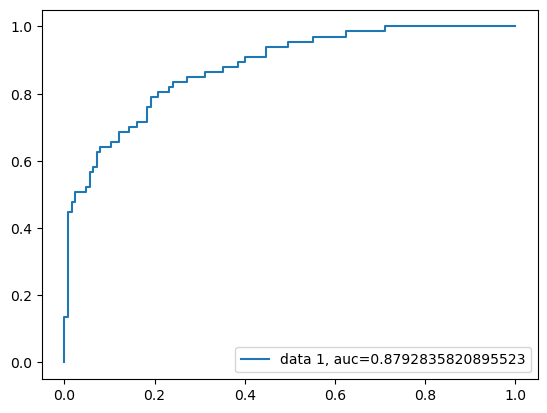

In [56]:
y_pred_proba = logreg_bch.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

En efecto, la curva ROC muestra que a nuestro modelo le cuesta identificar esos verdaderos positivos.

Revisemos como se comportan las semillas.

In [30]:
param_grid = {'random_state': range(1, 42)}
grid = GridSearchCV(
        LogisticRegression(max_iter=2000, solver='saga'),  # saga o liblinear/sag
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
)

grid.fit(X_train, y_train)
print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor accuracy CV:", grid.best_score_)

Mejores hiperparámetros: {'random_state': 1}
Mejor accuracy CV: 0.6840329835082459


c:\Users\ljpca\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Buscar semillas no parece ser una opcion util, solo permite reproducibilidad. Obvio pero comprobado.

Usaremos como semilla el numero 37.

In [31]:
pipe = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=2000, random_state=37, solver='saga')
)

param_grid = {
    'logisticregression__C':      np.logspace(-3, 3, 7),   # fuerza de regularización
    'logisticregression__penalty':['l1', 'l2', 'elasticnet'],
    'logisticregression__l1_ratio': [0, .5, 1]             # solo se usa con elasticnet
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("Mejores hiperparámetros:", grid.best_params_)
print("Mejor accuracy CV:", grid.best_score_)

Mejores hiperparámetros: {'logisticregression__C': 1.0, 'logisticregression__l1_ratio': 0, 'logisticregression__penalty': 'l1'}
Mejor accuracy CV: 0.7743928035982008


c:\Users\ljpca\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


In [32]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    logreg_bch, y_pred_logreg_bch, cnf_matrix_logreg_bch, acc_logreg_bch = puesta_punto_modelo(grid, X_train, X_test, y_train, y_test)

target_names = ['without diabetes', 'with diabetes']
print(classification_report(y_test, y_pred_logreg_bch, target_names=target_names))

                  precision    recall  f1-score   support

without diabetes       0.82      0.92      0.87       125
   with diabetes       0.81      0.63      0.71        67

        accuracy                           0.82       192
       macro avg       0.81      0.77      0.79       192
    weighted avg       0.82      0.82      0.81       192



c:\Users\ljpca\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1197: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Mejoramos un poco nuestro modelo benchmark tomando en cuenta un ajuste más profundo de hiperparámetros para diferentes métricas. Mejoró mucho? En definitiva no. La convergencia de los datos dado este dataset sintetico no ayuda mucho. **Deberiamos revisar otros modelos.**

### 5.2 Arbol de decisión

Iniciemos rápido con un arbol

In [41]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# looking for accuaracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7291666666666666


estamos lejos aun del modelo benchmark, quizás?

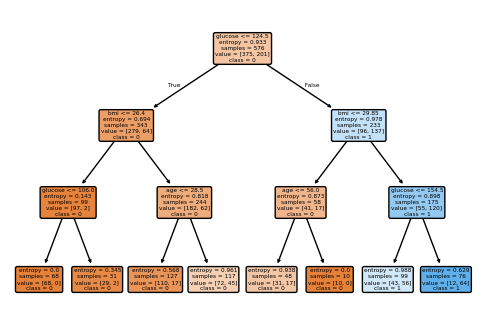

In [60]:

plt.figure(figsize=(6,4))
tree.plot_tree(clf,
               feature_names=feature_cols,
               class_names=['0','1'],
               filled=True,
               rounded=True)
plt.show()

In [56]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.765625


Mejoramos un poco.

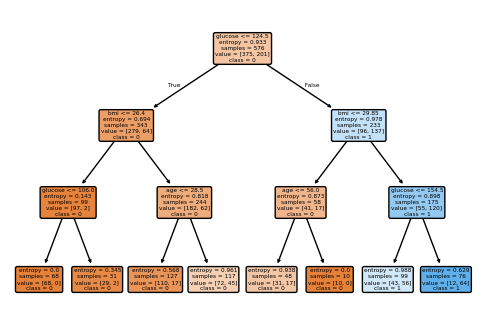

In [58]:

plt.figure(figsize=(6,4))
tree.plot_tree(clf,
               feature_names=feature_cols,
               class_names=['0','1'],
               filled=True,
               rounded=True)
plt.show()

Debemos podar este arbol. Ya encontramos que cambiar la semilla no ayuda pues mucho. Hagamos una busqueda en diferentes parámetros para encontrar la mejor combinación de hiperparámetros.

In [61]:
param_grid = {
    'criterion':    ['gini', 'entropy'],
    'max_depth':    list(range(1, 11)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf':  [1, 2, 4]
}

grid = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',   # 'roc_auc' -> AUC, accuaracy
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Mejores parámetros:", grid.best_params_)
print("Mejor accuracy CV:",  grid.best_score_)


Mejores parámetros: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}
Mejor accuracy CV: 0.7746463414634147


No mejora mucho, o quizás un 1 % pueda significar mucho. En cualquier caso existe n-combinaciones más de parámetros. Nos quedaremos con estas por ahora.

In [62]:
importances = clf.feature_importances_

# Crea un Series para ordenarlo y visualizarlo
fi = pd.Series(importances, index=X_train.columns)

# Ordénalo de mayor a menor y muéstralo
fi = fi.sort_values(ascending=False)
print(fi)

glucose     0.571035
bmi         0.293506
age         0.135459
pregnant    0.000000
insulin     0.000000
bp          0.000000
pedigree    0.000000
dtype: float64


Al parecer algunas features no son tan relevantes, quizás podríamos...

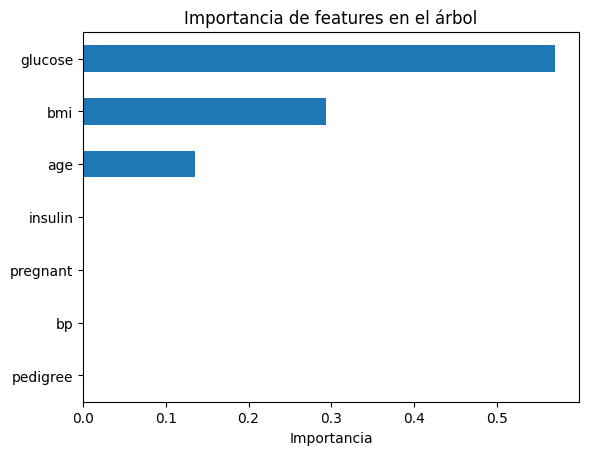

In [ ]:
fi.plot(kind='barh')
plt.xlabel('Importancia')
plt.title('Importancia de features en el árbol')
plt.gca().invert_yaxis()  # para que la más importante quede arriba
plt.show()

No usarlas? Igual el modelo no le está dando gran importancia a estas mismas. 

In [63]:

#Predict the response for test dataset
y_pred = grid.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))


Accuracy: 0.765625


In [64]:
target_names = ['without diabetes', 'with diabetes']
print(classification_report(y_test, y_pred, target_names=target_names))

                  precision    recall  f1-score   support

without diabetes       0.79      0.88      0.83       125
   with diabetes       0.71      0.55      0.62        67

        accuracy                           0.77       192
       macro avg       0.75      0.72      0.73       192
    weighted avg       0.76      0.77      0.76       192



No parece ser mejor que nuestra regresión logística

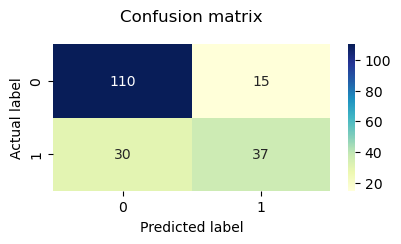

In [72]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=[0,1] # name  of classes
tick_marks = np.arange(len(class_names))
# create heatmap
plt.figure(figsize=(4,2))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
#ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

Quizás el problemas de las clases desbalanceadas sea un punto a considerar.

### 5.3 Bosque de decisión

Dos arboles piensan más que uno.

In [73]:
# 1. Define el modelo benchmark
rf_bench = RandomForestClassifier(
    n_estimators=100,      # número de árboles
    max_depth=None,        # profundidad máxima (None = hasta hoja pura)
    random_state=42,       # semilla para reproducibilidad
    n_jobs=-1              # usar todos los cores
)

# 2. Ajusta, predice y evalúa
rf_bench.fit(X_train, y_train)
y_pred_rf = rf_bench.predict(X_test)

# 3. Métricas clave
acc_rf    = metrics.accuracy_score(y_test, y_pred_rf)
cm_rf     = metrics.confusion_matrix(y_test, y_pred_rf)
roc_auc_rf = metrics.roc_auc_score(y_test, rf_bench.predict_proba(X_test)[:,1])

print(f"Accuracy RF:    {acc_rf:.4f}")
print(f"ROC AUC RF:     {roc_auc_rf:.4f}")
print("Matriz de confusión:")

Accuracy RF:    0.8021
ROC AUC RF:     0.8798
Matriz de confusión:


In [74]:
target_names = ['without diabetes', 'with diabetes']
print(classification_report(y_test, y_pred_rf, target_names=target_names))

                  precision    recall  f1-score   support

without diabetes       0.81      0.90      0.86       125
   with diabetes       0.77      0.61      0.68        67

        accuracy                           0.80       192
       macro avg       0.79      0.76      0.77       192
    weighted avg       0.80      0.80      0.80       192



Mismos problemas. Quizás.

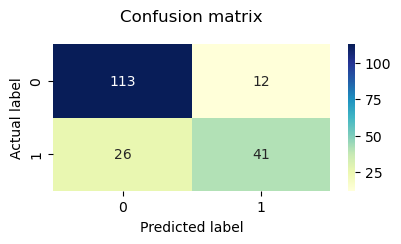

In [75]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=[0,1] # name  of classes
tick_marks = np.arange(len(class_names))
# create heatmap
plt.figure(figsize=(4,2))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cm_rf), annot=True, cmap="YlGnBu" ,fmt='g')
#ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

Busquemos una mejor combinación:

In [ ]:
# Modelo base a optimizar
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# No usaremos muchos
# El tiempo de ejcución TARDA!
param_grid = {
    'n_estimators':      [50, 100, 200],   # número de árboles en el bosque
    'max_depth':         [None, 10, 20, 30],  # profundidad máxima de cada árbol
    'min_samples_split': [2, 5, 10],  # min. muestras para dividir un nodo
    'min_samples_leaf':  [1, 2, 4],  # min. muestras en una hoja
    'max_features':      ['sqrt', 'log2', None] # número de features consideradas en cada split
}

# configuremos nuestra matriz de posibilidades
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,       # 5-fold cross-validation
    scoring='accuracy',   # puedes usar 'roc_auc' si prefieres AUC
    n_jobs=-1,  # usar todos los cores
    verbose=1       # ver progreso
)

# entrenamos!
grid_rf.fit(X_train, y_train)

# revisemos
print("Mejores hiperparámetros:", grid_rf.best_params_)
print(f"Mejor accuracy CV: {grid_rf.best_score_:.4f}")

# seleccionemos el mejor estimador!
best_rf = grid_rf.best_estimator_
y_pred = best_rf.predict(X_test)

from sklearn import metrics
print(f"Accuracy en test: {metrics.accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC en test:  {metrics.roc_auc_score(y_test, best_rf.predict_proba(X_test)[:,1]):.4f}")


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Mejores hiperparámetros: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Mejor accuracy CV: 0.7553
Accuracy en test: 0.7969
ROC AUC en test:  0.8812
Matriz de confusión:
 [[114  11]
 [ 28  39]]


Realmente estamos "sacrificando" verdaderos positivos. El modelo sigue algo confuso.

In [ ]:
print("Matriz de confusión:\n", metrics.confusion_matrix(y_test, y_pred))

### 5.4 Balanceo de clases

### 6. Comparación

In [ ]:
#hacer random forest

## Conclusiones

In [ ]:
#comparar desempeño de los 3

In [ ]:
#comparar estabilidad de los 3

In [ ]:
#sacar características de precision, y demás de los 3 y compararlos

In [ ]:
#sacar conclusion de los hiperparámetros